# CIRCLE PACKING

[loader] units=mm, px->mm=0.26458, scale_cm_per_px=0.026458333333333334
hex grid : 100
after greedy : 100
after compaction : 100
final count : 100


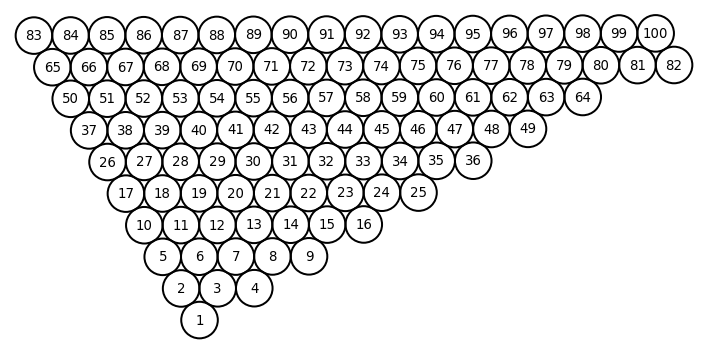

Area that could still host a centre: 2465.5 mm²
Largest empty circle radius: 1.19 mm (2.38 mm diameter)
Saved 100 circle centres to out.csv


In [8]:
import circle_packing as cp

from pathlib import Path
from shapely.geometry import Point
import numpy as np

json_file = "input_json/input_misure/input_misure_12.json"  # Path to the input JSON file
out_csv = "out.csv"
R = 9.0  # mm, radius of an 18650 seen from the top
EPS = 0.2          # slack in adjacency threshold    S = 10


poly, _, meta = cp.load_boundary(Path(json_file), to_units="mm", require_scale=False)
print(f"[loader] units=mm, px->mm={meta['px_to_mm']:.5f}, scale_cm_per_px={meta['scale_cm_per_px']}")

# 1 ─ aligned hex grid (finer phase scan gives 1-3 extra cells)
centres = cp.best_hex_seed_two_angles(poly, n_phase=16, r=R)
print("hex grid :", len(centres))

# pso refine (deleted for now, see below)
#centres1 = pso_refine(centres0, poly)
#print("PSO done")

# 2 ─ first greedy insertion (fills obvious edge gaps)
centres = cp.greedy_insert(poly, centres, r=R, trials=1000, max_pass=6)
print("after greedy :", len(centres))

# 3 ─ local compaction (Python re-implementation of Zhou’s batch-BFGS)
centres = cp.batch_bfgs_compact(centres, R, poly, n_pass=4)
print("after compaction :", len(centres))

# 4 ─ second greedy pass (micron pockets now opened by compactor)
centres = cp.greedy_insert(poly, centres, r=R, trials=1000, max_pass=3)
print("final count :", len(centres))

prev = len(centres)
t0 = cp.perf_counter()
centres = cp.skeleton_insert(poly, centres, r=R, step=2.0)
t1 = cp.perf_counter()
#cp.plot_phase(poly, centres, added_idx=np.arange(prev, len(centres)), title="After skeleton insert", r=R, time_s=t1 - t0)
cp.plot_numbered_circles(centres, r=9.0, edgecolor="k", facecolor="none", number_color="k")

# ───▶  DIAGNOSTIC POCKET ANALYSIS  ◀─────────────────────────────────────
free     = poly.buffer(-R).buffer(0)            # safe interior strip
hull     = cp.unary_union([Point(x, y).buffer(R) for x, y in centres])
residual = free.difference(hull)

print(f"Area that could still host a centre: {residual.area:.1f} mm²")

# Optional: largest empty circle (Shapely≥2.0 only)
try:
    from shapely import maximum_inscribed_circle

    rad, centre_pt = cp.largest_empty_circle(residual)
    if rad > 0:
        print(f"Largest empty circle radius: {rad:.2f} mm "
            f"({2*rad:.2f} mm diameter)")
    else:
        print("Residual pocket too thin for even a tiny extra cell.")
except ImportError:
    pass
# ─────────────────────────────────────────────────────────────────────────

# 5 ─ save + preview
np.savetxt(out_csv, centres, delimiter=",", header="x,y", comments="")
print(f"Saved {centres.shape[0]} circle centres to {out_csv}")

# VARI TENTATIVI PER IL LAYOUT

nodi con deg_in=0: 1

Starting CP-SAT solver v9.14.6206
Parameters: random_seed: 0 max_time_in_seconds: 7 log_search_progress: true search_branching: PORTFOLIO_SEARCH cp_model_presolve: true linearization_level: 0 num_search_workers: 6 randomize_search: true cp_model_probing_level: 0 symmetry_level: 2

Initial optimization model '': (model_fingerprint: 0x419fa5ebfc4476c1)
#Variables: 27'521 (#bools: 34 #ints: 35 in objective) (24'431 primary variables)
  - 27'486 Booleans in [0,1]
  - 1 in [0,4]
  - 34 in [0,420]
#kLinear1: 34
#kLinear2: 46'233
#kLinear3: 315
#kLinearN: 2'823 (#terms: 48'171)

Starting presolve at 0.02s
  1.07e-02s  0.00e+00d  [DetectDominanceRelations] 
  8.23e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=3 #num_dual_strengthening=2 
  6.31e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=3'034 #potential_subsets=34 
  6.82e-04s  0.00e+00d  [DetectDuplicateColumns] 
  1.13e-03s  0.00e+00d  [DetectDuplicateConstraints] #duplicates=82 
[Symmetry] Gra

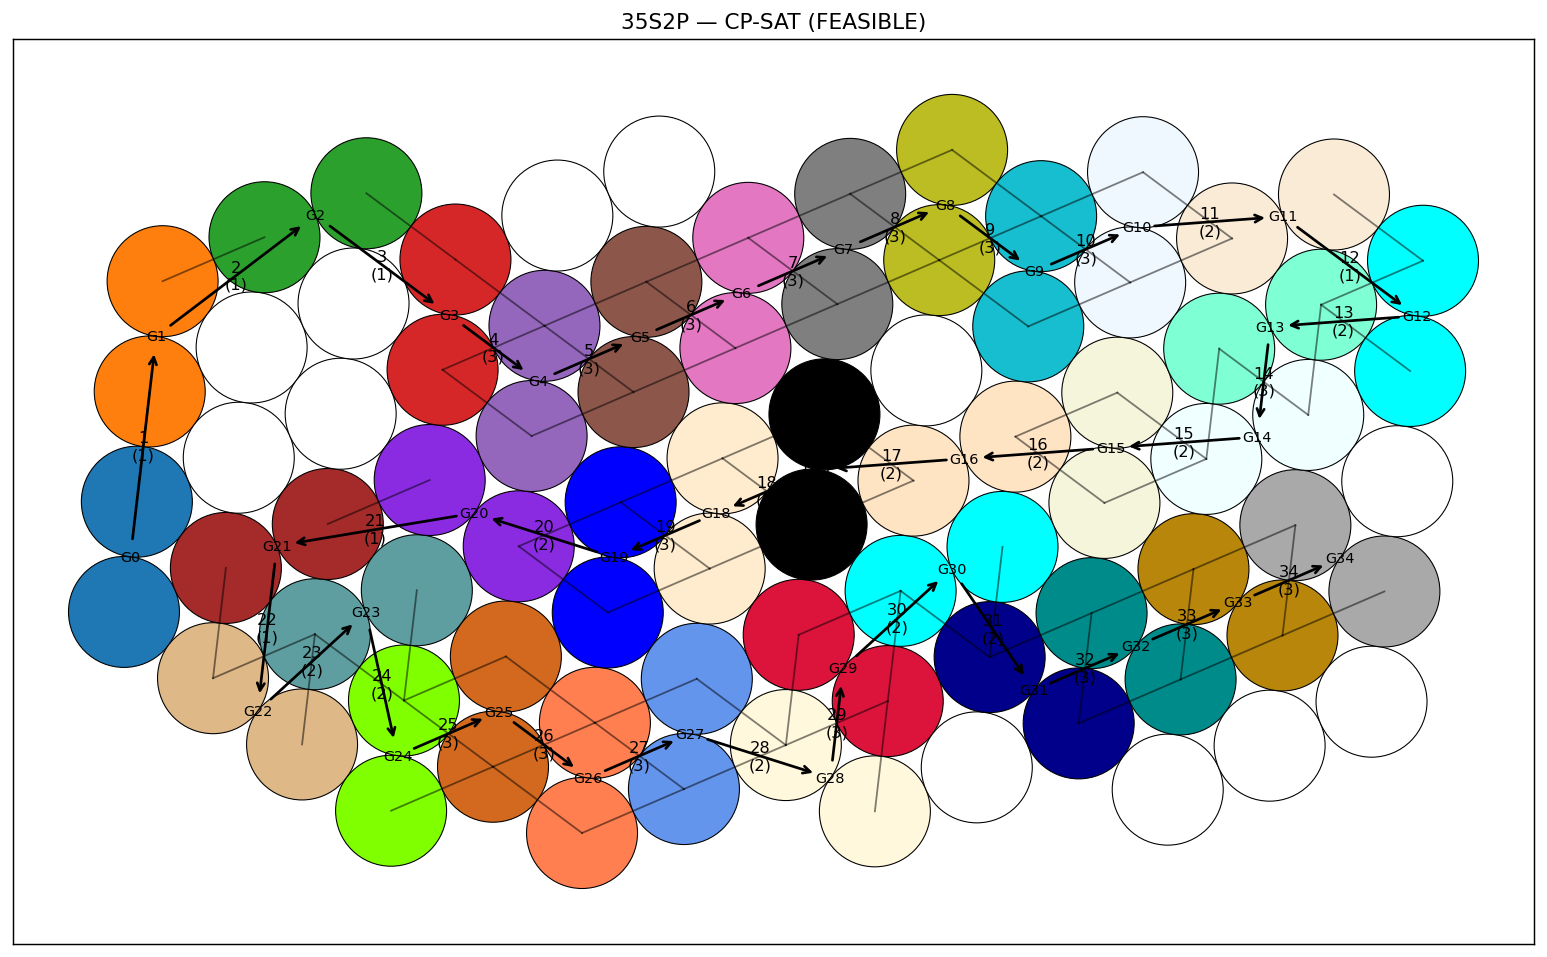

In [ ]:
import battery_layout_cpsat_v2 as bc
import pandas as pd
from ortools.sat.python import cp_model


csv = "out.csv"
S = 35
P = 2
radius = 9.0
tol = 2
time_budget = 30
degree_cap = 6
enforce_degree = False
target_T=2*P
use_hole_penality=False

df = pd.read_csv(csv)
coords = df[['x','y']].to_numpy()

# tuning senza snake
pack = bc.auto_tune_and_solve(
    coords, S, P, radius, tol,
    time_budget=time_budget,
    target_T=target_T,             
    degree_cap=degree_cap,
    enforce_degree=enforce_degree,
    profiles=("fast","fast","quality"),
    seeds=(0,1,2,3),
    workers=6,
    use_hole_penality=use_hole_penality,
    stripe_mode="auto"
)

status, solver, x, r, L, z1, z2, E, T = pack
status_name = {cp_model.OPTIMAL:"OPTIMAL", cp_model.FEASIBLE:"FEASIBLE",
                cp_model.INFEASIBLE:"INFEASIBLE", cp_model.MODEL_INVALID:"MODEL_INVALID",
                cp_model.UNKNOWN:"UNKNOWN"}.get(status, str(status))
print("Solver status:", status_name)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    links = [int(solver.Value(v)) for v in L]
    tval = solver.Value(T) if T is not None else None
    print(f"min_k Lk = {tval}   sum(L) = {sum(links)}   per-k: {links}")
    bc.plot_solution(
        coords, radius, S, x, z1, z2, E, L, solver,
        title=f"{S}S{P}P — CP-SAT ({status_name})",
        save=None, show_links=True, show_arrows=True
    )
else:
    print("Nessuna soluzione trovata entro il budget.")

nodi con deg_in=0: 1

Starting CP-SAT solver v9.14.6206
Parameters: random_seed: 0 max_time_in_seconds: 75 log_search_progress: true search_branching: PORTFOLIO_SEARCH cp_model_presolve: true linearization_level: 0 num_search_workers: 6 randomize_search: true cp_model_probing_level: 0 symmetry_level: 2

Initial optimization model '': (model_fingerprint: 0xa52f223e6dcbf332)
#Variables: 13'709 (#bools: 15 #ints: 17 in objective) (11'890 primary variables)
  - 13'692 Booleans in [0,1]
  - 1 in [0,10]
  - 1 in [0,90]
  - 15 in [0,446]
#kLinear1: 15
#kLinear2: 22'675
#kLinear3: 68
#kLinearN: 1'690 (#terms: 24'626)

Starting presolve at 0.03s
  7.17e-03s  0.00e+00d  [DetectDominanceRelations] 
  4.83e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=3 #num_dual_strengthening=2 
  1.43e-03s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=1'709 #potential_subsets=15 
  8.17e-04s  0.00e+00d  [DetectDuplicateColumns] 
  6.44e-04s  0.00e+00d  [DetectDuplicateConstraints] 
[Symmetry] G

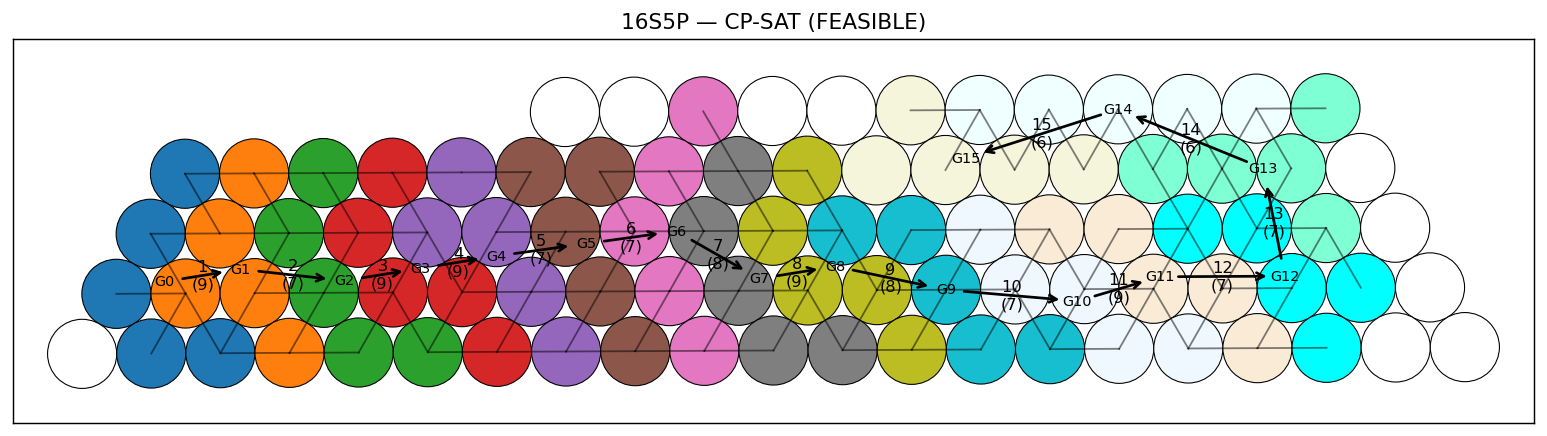

In [32]:
import battery_layout_cpsat_v3 as bc
import pandas as pd
from ortools.sat.python import cp_model


csv = "out.csv"
S = 16
P = 5
radius = 9.0
tol = 2
time_budget = 300
degree_cap = 6
enforce_degree = False
target_T=2*P
use_hole_penality=True

df = pd.read_csv(csv)
coords = df[['x','y']].to_numpy()

# tuning senza snake
pack = bc.auto_tune_and_solve(
    coords, S, P, radius, tol,
    time_budget=time_budget,
    target_T=target_T,             
    degree_cap=degree_cap,
    enforce_degree=enforce_degree,
    profiles=("fast","fast","quality"),
    seeds=(0,1,2,3),
    workers=6,
    use_hole_penality=use_hole_penality,
    stripe_mode="auto"
)

status, solver, x, r, L, z1, z2, E, T = pack
status_name = {cp_model.OPTIMAL:"OPTIMAL", cp_model.FEASIBLE:"FEASIBLE",
                cp_model.INFEASIBLE:"INFEASIBLE", cp_model.MODEL_INVALID:"MODEL_INVALID",
                cp_model.UNKNOWN:"UNKNOWN"}.get(status, str(status))
print("Solver status:", status_name)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    links = [int(solver.Value(v)) for v in L]
    tval = solver.Value(T) if T is not None else None
    print(f"min_k Lk = {tval}   sum(L) = {sum(links)}   per-k: {links}")
    bc.plot_solution(
        coords, radius, S, x, z1, z2, E, L, solver,
        title=f"{S}S{P}P — CP-SAT ({status_name})",
        save=None, show_links=True, show_arrows=True
    )
else:
    print("Nessuna soluzione trovata entro il budget.")

# PER ORA QUELLA CHE FUNZIONA MEGLIO SU TUTTI I CASI

nodi con deg_in=0: 1

Starting CP-SAT solver v9.14.6206
Parameters: random_seed: 0 max_time_in_seconds: 75 log_search_progress: true search_branching: PORTFOLIO_SEARCH cp_model_presolve: true linearization_level: 0 num_search_workers: 6 randomize_search: true cp_model_probing_level: 0 symmetry_level: 2

Initial optimization model '': (model_fingerprint: 0x7974b27e0614ca5f)
#Variables: 14'027 (#bools: 17 #ints: 17 in objective) (12'116 primary variables)
  - 14'010 Booleans in [0,1]
  - 1 in [0,10]
  - 1 in [0,90]
  - 15 in [0,446]
#kLinMax: 2 (#expressions: 180)
#kLinear1: 59
#kLinear2: 23'357
#kLinear3: 248
#kLinearN: 1'736 (#terms: 24'948)

Starting presolve at 0.01s
  4.95e-03s  0.00e+00d  [DetectDominanceRelations] 
  4.10e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=3 #num_dual_strengthening=2 
  2.19e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=1'709 #potential_subsets=15 
  5.38e-04s  0.00e+00d  [DetectDuplicateColumns] 
  4.75e-04s  0.00e+00d  [DetectDu

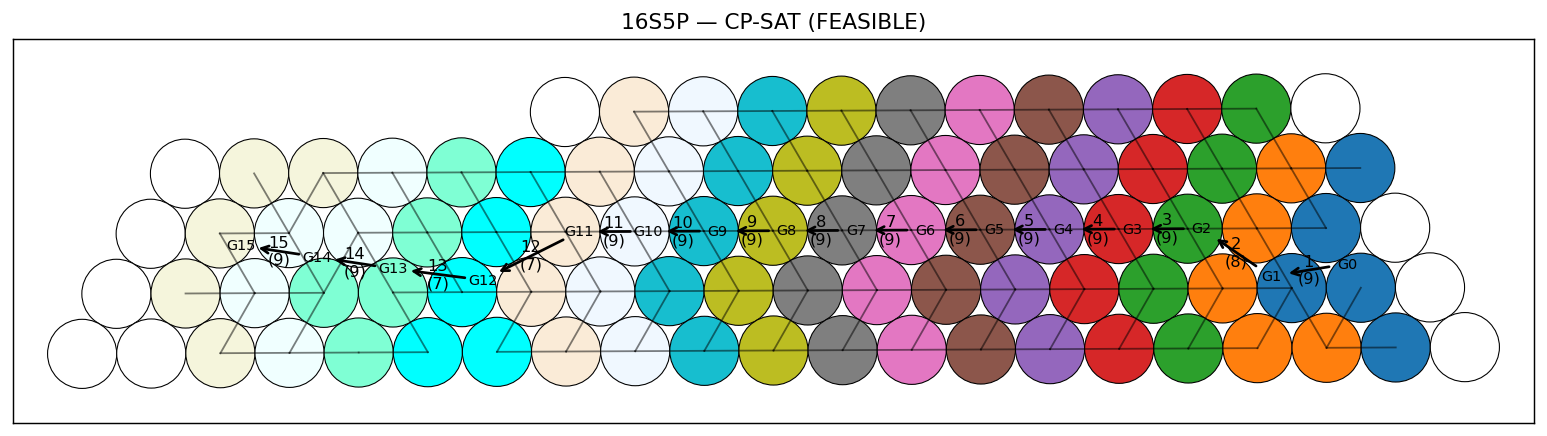

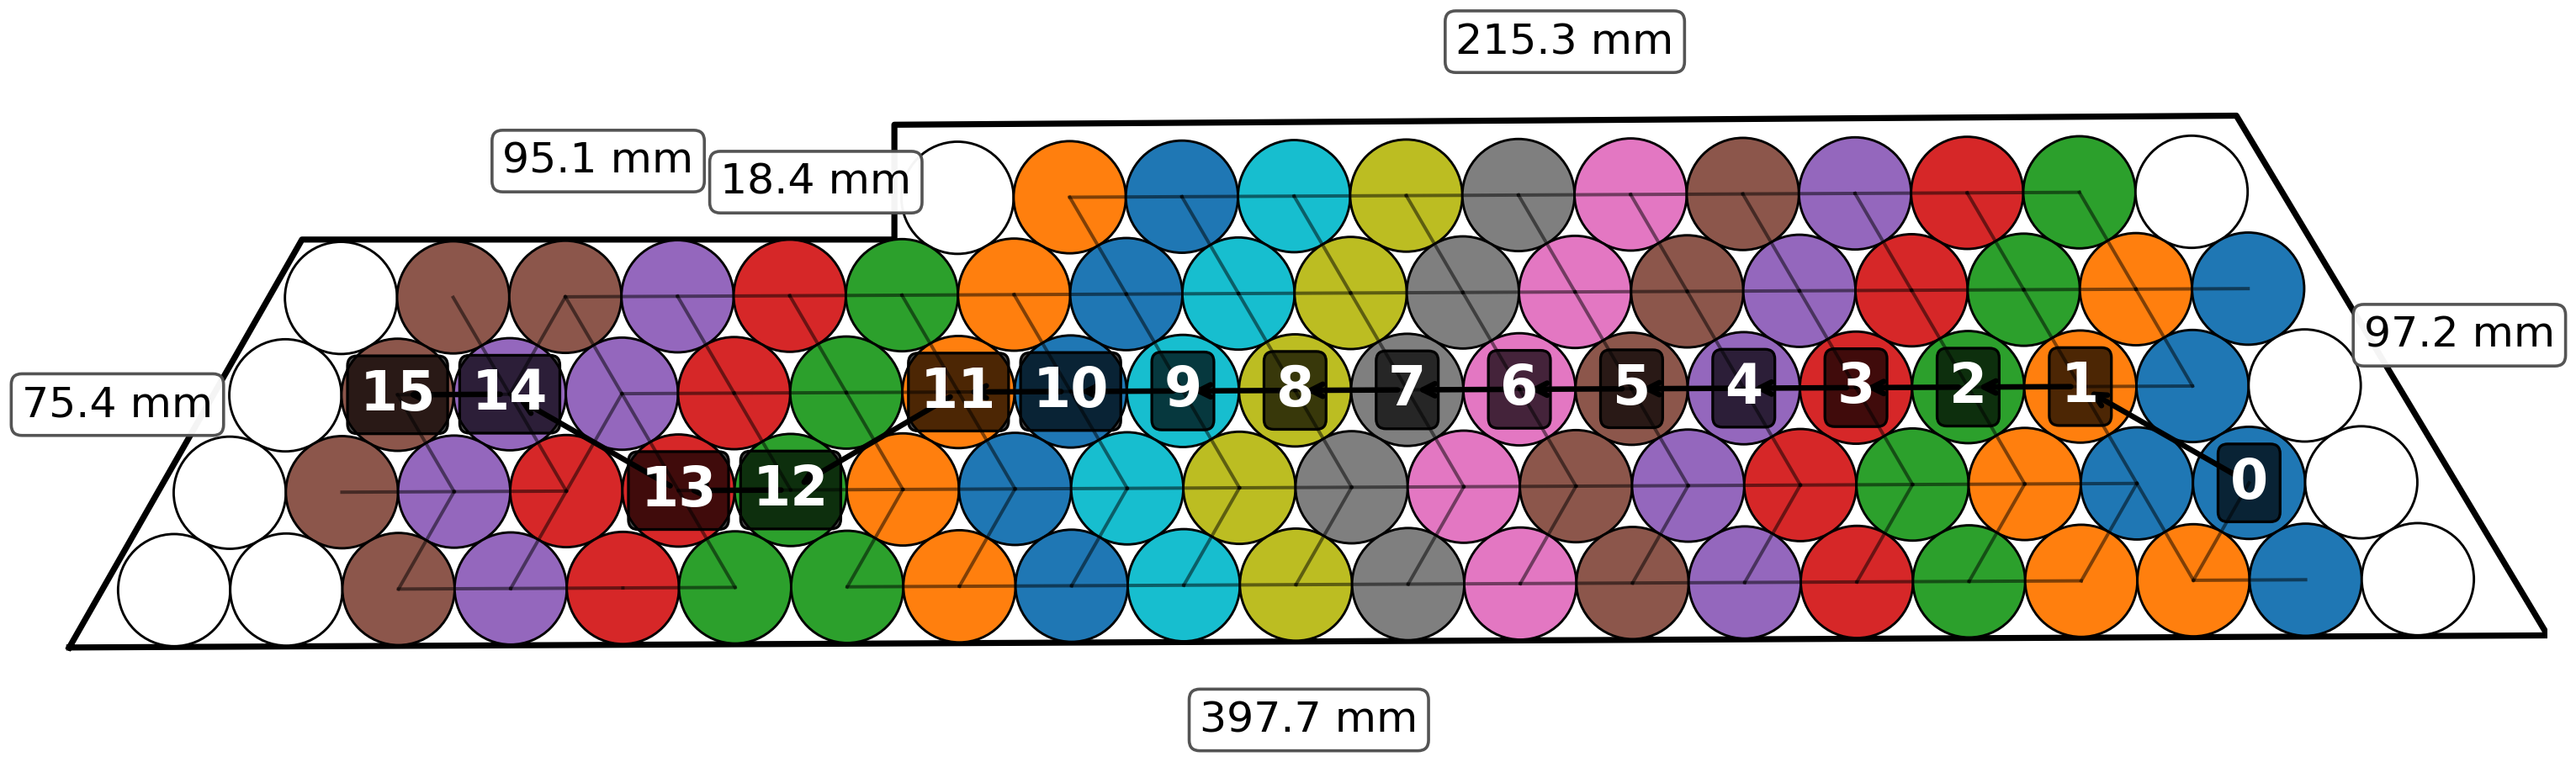

In [33]:
import battery_layout_cpsat_v4 as bc
import pandas as pd
from ortools.sat.python import cp_model


csv = "out.csv"
S = 16
P = 5
radius = 9.0
tol = 2
time_budget = 300
degree_cap = 6
enforce_degree = False
target_T=2*P
use_hole_penality=True

df = pd.read_csv(csv)
coords = df[['x','y']].to_numpy()

# tuning senza snake
pack = bc.auto_tune_and_solve(
    coords, S, P, radius, tol,
    time_budget=time_budget,
    target_T=target_T,             
    degree_cap=degree_cap,
    enforce_degree=enforce_degree,
    profiles=("fast","fast","quality"),
    seeds=(0,1,2,3),
    workers=6,
    use_hole_penality=use_hole_penality,
    stripe_mode="row"
)

status, solver, x, r, L, z1, z2, E, T = pack
status_name = {cp_model.OPTIMAL:"OPTIMAL", cp_model.FEASIBLE:"FEASIBLE",
                cp_model.INFEASIBLE:"INFEASIBLE", cp_model.MODEL_INVALID:"MODEL_INVALID",
                cp_model.UNKNOWN:"UNKNOWN"}.get(status, str(status))
print("Solver status:", status_name)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    links = [int(solver.Value(v)) for v in L]
    tval = solver.Value(T) if T is not None else None
    print(f"min_k Lk = {tval}   sum(L) = {sum(links)}   per-k: {links}")
    bc.plot_solution(
        coords, radius, S, x, z1, z2, E, L, solver,
        title=f"{S}S{P}P — CP-SAT ({status_name})",
        save=None, show_links=True, show_arrows=True
    )

    bc.plot_solution2(
        coords, radius, S, x, z1, z2, E, L, solver,
        boundary=json_file,
        show_links=True,          # lascia i link sottili (o False per toglierli)
        show_arrows=True,         # frecce tra le celle con i numeri
        flip_vertical=True,
        fs_group=18, fs_dim=14,   # testi più grandi
    )
else:
    print("Nessuna soluzione trovata entro il budget.")

nodi con deg_in=0: 0

Starting CP-SAT solver v9.14.6206
Parameters: random_seed: 0 max_time_in_seconds: 75 log_search_progress: true search_branching: PORTFOLIO_SEARCH cp_model_presolve: true linearization_level: 0 num_search_workers: 6 randomize_search: true cp_model_probing_level: 0 symmetry_level: 2

Initial optimization model '': (model_fingerprint: 0x42e3e2a24a18ff8f)
#Variables: 11'865 (#bools: 14 #ints: 14 in objective) (10'690 primary variables)
  - 11'006 Booleans in [0,1]
  - 845 in [0,4]
  - 1 in [0,10]
  - 1 in [0,65]
  - 12 in [0,314]
#kLinMax: 2 (#expressions: 130)
#kLinear1: 3'290 (#enforced: 2'535)
#kLinear2: 21'596 (#enforced: 4'082)
#kLinear3: 979
#kLinearN: 1'119 (#terms: 18'730)

Starting presolve at 0.03s
Large number of fixed variables 9'260 / 11'865, doing a first remapping phase to go down to 2'605 variables.
TODO: 1878 fixed variables still required in the model!
  9.76e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.13e-02s  0.00e+00d  [PresolveToFixPoint] #n

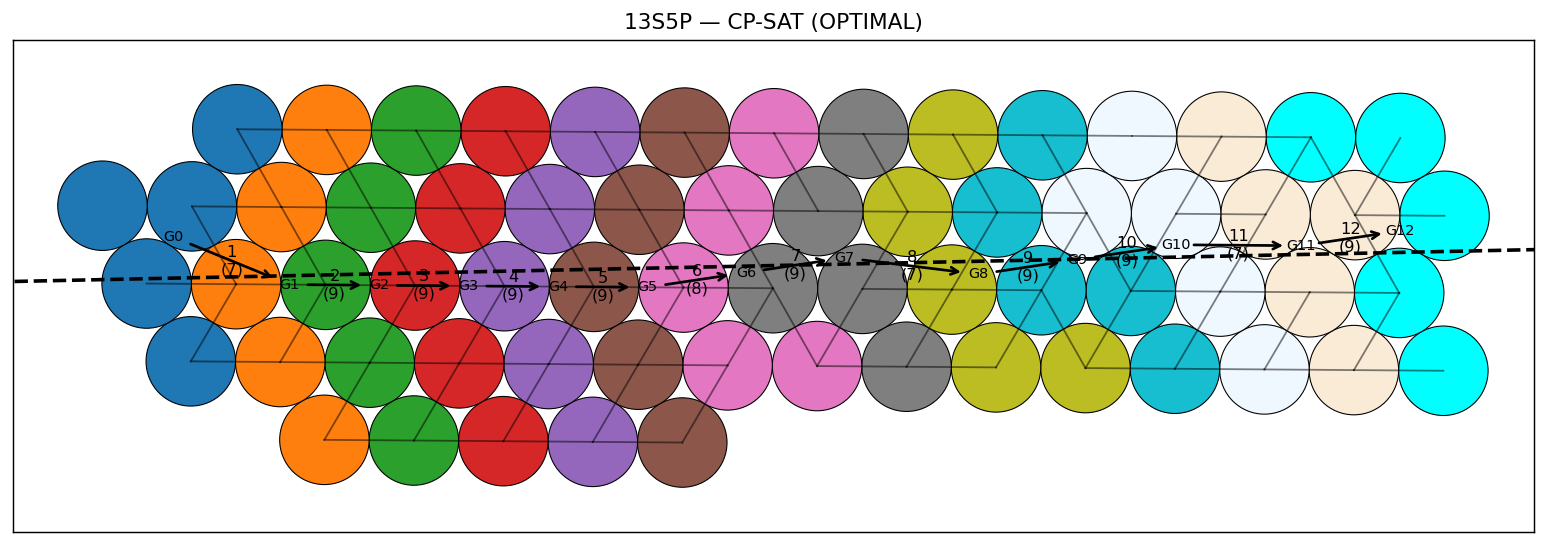

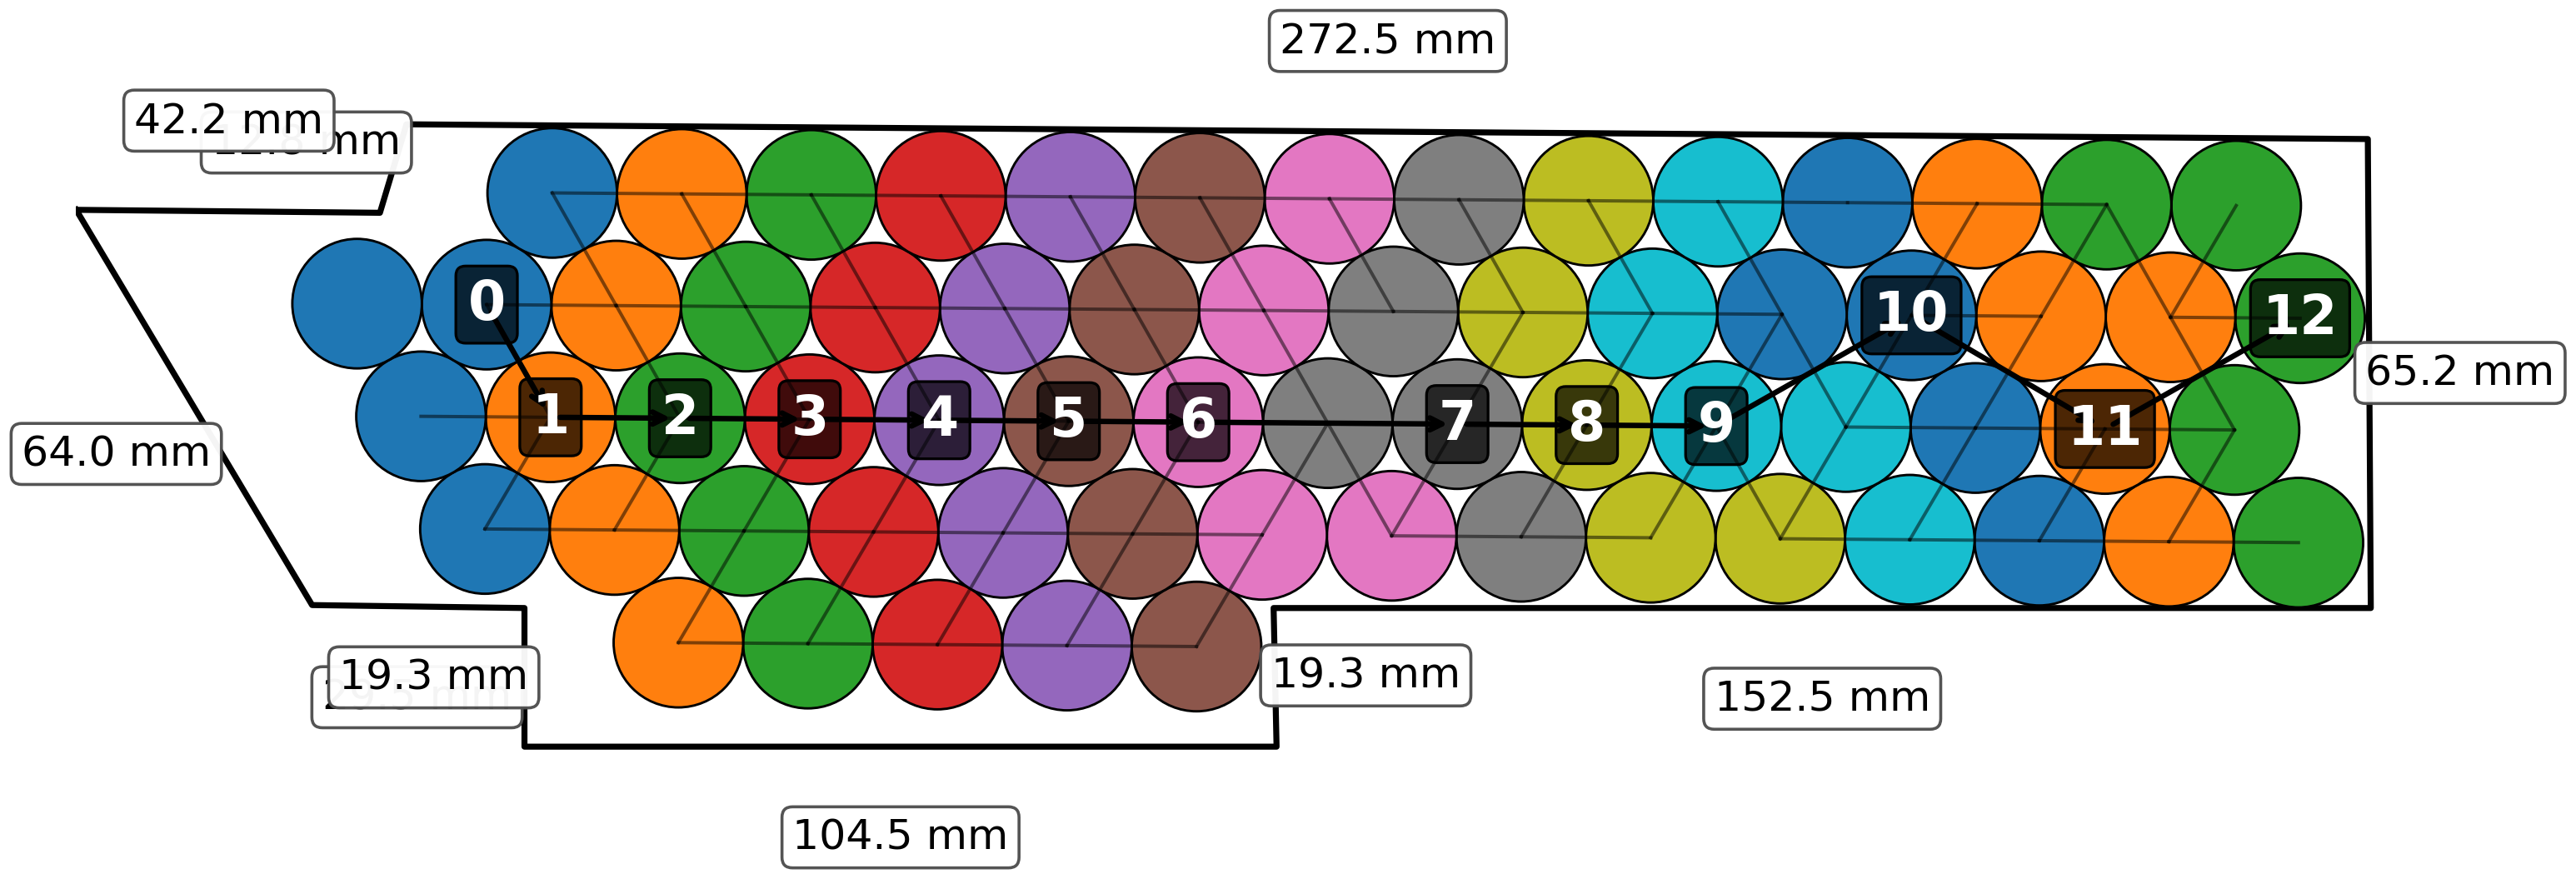

In [ ]:
import battery_layout_cpsat_v5 as bc
import pandas as pd
from ortools.sat.python import cp_model


csv = "out.csv"
S = 10
P = 10
radius = 9.0
tol = 2
time_budget = 300
degree_cap = 6
enforce_degree = False
target_T=2*P
use_hole_penality=True

df = pd.read_csv(csv)
coords = df[['x','y']].to_numpy()

# tuning senza snake
pack = bc.auto_tune_and_solve(
    coords, S, P, radius, tol,
    time_budget=time_budget,
    target_T=target_T,             
    degree_cap=degree_cap,
    enforce_degree=enforce_degree,
    profiles=("fast","fast","quality"),
    seeds=(0,1,2,3),
    workers=6,
    use_hole_penality=use_hole_penality,
    stripe_mode="axis"
)

status, solver, x, r, L, z1, z2, E, T = pack
status_name = {cp_model.OPTIMAL:"OPTIMAL", cp_model.FEASIBLE:"FEASIBLE",
                cp_model.INFEASIBLE:"INFEASIBLE", cp_model.MODEL_INVALID:"MODEL_INVALID",
                cp_model.UNKNOWN:"UNKNOWN"}.get(status, str(status))
print("Solver status:", status_name)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    links = [int(solver.Value(v)) for v in L]
    tval = solver.Value(T) if T is not None else None
    print(f"min_k Lk = {tval}   sum(L) = {sum(links)}   per-k: {links}")
    e1, e2 = bc.pca_axes(coords)
    axis = e1
    bc.plot_solution(coords, radius, S, x, z1, z2, E, L, solver,
                    title=f"{S}S{P}P — CP-SAT ({status_name})",
                    show_links=True, show_arrows=True,
                    axis_vec=axis, start_end="min")
    bc.plot_solution2(
        coords, radius, S, x, z1, z2, E, L, solver,
        boundary=json_file,
        show_links=True,          # lascia i link sottili (o False per toglierli)
        show_arrows=True,         # frecce tra le celle con i numeri
        flip_vertical=True,
        fs_group=18, fs_dim=14,   # testi più grandi
    )
else:
    print("Nessuna soluzione trovata entro il budget.")

In [35]:
import battery_layout_cpsat_v6 as bc
import pandas as pd
from ortools.sat.python import cp_model


csv = "out.csv"
S = 8
P = 10
radius = 9.0
tol = 2
time_budget = 300
degree_cap = 6
enforce_degree = False
target_T=2*P
use_hole_penality=True

df = pd.read_csv(csv)
coords = df[['x','y']].to_numpy()

# tuning senza snake
pack = bc.auto_tune_and_solve(
    coords, S, P, radius, tol,
    time_budget=time_budget,
    target_T=target_T,             
    degree_cap=degree_cap,
    enforce_degree=enforce_degree,
    profiles=("fast", "quality"),
    seeds=(0,1,2,3),
    workers=6,
    use_hole_penality=use_hole_penality,
    stripe_mode="rect"
)

status, solver, x, r, L, z1, z2, E, T = pack
status_name = {cp_model.OPTIMAL:"OPTIMAL", cp_model.FEASIBLE:"FEASIBLE",
                cp_model.INFEASIBLE:"INFEASIBLE", cp_model.MODEL_INVALID:"MODEL_INVALID",
                cp_model.UNKNOWN:"UNKNOWN"}.get(status, str(status))
print("Solver status:", status_name)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    links = [int(solver.Value(v)) for v in L]
    tval = solver.Value(T) if T is not None else None
    print(f"min_k Lk = {tval}   sum(L) = {sum(links)}   per-k: {links}")
    e1, e2 = bc.pca_axes(coords)
    axis = e1
    bc.plot_solution(coords, radius, S, x, z1, z2, E, L, solver,
                    title=f"{S}S{P}P — CP-SAT ({status_name})",
                    show_links=True, show_arrows=True,
                    axis_vec=axis, start_end="min")
else:
    print("Nessuna soluzione trovata entro il budget.")

nodi con deg_in=0: 0

Starting CP-SAT solver v9.14.6206
Parameters: random_seed: 0 max_time_in_seconds: 75 log_search_progress: true search_branching: PORTFOLIO_SEARCH cp_model_presolve: true linearization_level: 0 num_search_workers: 6 randomize_search: true cp_model_probing_level: 0 symmetry_level: 2

Initial optimization model '': (model_fingerprint: 0xe28dc406129bf84c)
#Variables: 10'443 (#bools: 9 #ints: 9 in objective) (9'292 primary variables)
  - 9'714 Booleans in [0,1]
  - 720 in [0,9]
  - 1 in [0,20]
  - 1 in [0,90]
  - 7 in [0,446]
#kLinMax: 2 (#expressions: 180)
#kLinear1: 2'204 (#enforced: 2'160)
#kLinear2: 19'037 (#enforced: 3'568)
#kLinear3: 904
#kLinearN: 1'064 (#terms: 16'556)

Starting presolve at 0.01s
  2.98e-03s  0.00e+00d  [DetectDominanceRelations] 
  3.35e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  1.82e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=1'717 #potential_subsets=7 
  6.95e-04s  0.00e+00d  [Detect